In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
df = pd.read_excel("BaseFeaturesHH.xlsx")

df

,Unnamed: 0,From Timestamp,HH Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%)
0,0,2018-01-01 00:00:00,12.80,0,0.0,1,1,6.4,1.9,82.76
1,1,2018-01-01 00:30:00,12.30,0,0.5,1,1,6.4,1.9,82.76
2,2,2018-01-01 01:00:00,13.50,0,1.0,1,1,6.6,2.4,80.14
3,3,2018-01-01 01:30:00,11.90,0,1.5,1,1,6.6,2.4,80.14
4,4,2018-01-01 02:00:00,12.80,0,2.0,1,1,6.1,2.0,84.33
...,...,...,...,...,...,...,...,...,...,...
35035,35035,2019-12-31 21:30:00,13.56,1,21.5,0,12,6.5,3.3,88.23
35036,35036,2019-12-31 22:00:00,13.81,1,22.0,0,12,6.6,4.4,87.69
35037,35037,2019-12-31 22:30:00,14.12,1,22.5,0,12,6.6,4.4,87.69
35038,35038,2019-12-31 23:00:00,14.50,1,23.0,0,12,6.7,4.1,88.13


In [4]:
df = df.drop('Unnamed: 0', axis = 1)
df

,From Timestamp,HH Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%)
0,2018-01-01 00:00:00,12.80,0,0.0,1,1,6.4,1.9,82.76
1,2018-01-01 00:30:00,12.30,0,0.5,1,1,6.4,1.9,82.76
2,2018-01-01 01:00:00,13.50,0,1.0,1,1,6.6,2.4,80.14
3,2018-01-01 01:30:00,11.90,0,1.5,1,1,6.6,2.4,80.14
4,2018-01-01 02:00:00,12.80,0,2.0,1,1,6.1,2.0,84.33
...,...,...,...,...,...,...,...,...,...
35035,2019-12-31 21:30:00,13.56,1,21.5,0,12,6.5,3.3,88.23
35036,2019-12-31 22:00:00,13.81,1,22.0,0,12,6.6,4.4,87.69
35037,2019-12-31 22:30:00,14.12,1,22.5,0,12,6.6,4.4,87.69
35038,2019-12-31 23:00:00,14.50,1,23.0,0,12,6.7,4.1,88.13


In [5]:
lagNumberStart = 1
lagNumberEnd = 8

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    df[name] = df['HH Electricity (kWh)'].shift(48*i)

i = list(range(lagNumberEnd*48))
df = df.drop(i)


feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']   

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    feature_cols.append(name)
    
X = df[feature_cols].copy() #input features for fitting

Xtrain = df.iloc[:-(3*48)]
Xvalidate = df.iloc[-(3*48):]

X1 = Xtrain[feature_cols] # Features
y1 = Xtrain['HH Electricity (kWh)'] # Target variable

X2 = Xvalidate[feature_cols] # Features
y2 = Xvalidate['HH Electricity (kWh)'] # Target variable

scaler = StandardScaler() #scaling
scaler.fit(X)
X1scaled = scaler.transform(X1)
X2scaled = scaler.transform(X2)


# Random Forest Regressor

In [9]:
N = range(10,1011,100)

RFR = GridSearchCV(RandomForestRegressor(random_state=42), {
    'n_estimators': N
}, cv=5, return_train_score=False)
RFR.fit(X1scaled, y1)

RFR_results = pd.DataFrame(RFR.cv_results_)
RFR_results = RFR_results[['param_n_estimators', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])
RFR_results

,param_n_estimators,mean_test_score,rank_test_score
8,810,0.831909,1
9,910,0.831898,2
10,1010,0.831886,3
7,710,0.831744,4
6,610,0.831690,5
5,510,0.831659,6
4,410,0.831289,7
3,310,0.831191,8
1,110,0.831172,9
2,210,0.830953,10


In [10]:
N = range(5,96,10)

RFR1 = GridSearchCV(RandomForestRegressor(random_state=42), {
    'n_estimators': N
}, cv=5, return_train_score=False)
RFR1.fit(X1scaled, y1)

RFRresults1 = pd.DataFrame(RFR1.cv_results_)
RFRresults1 = RFRresults1[['param_n_estimators', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])
RFRresults1



,param_n_estimators,mean_test_score,rank_test_score
8,85,0.830835,1
9,95,0.830818,2
7,75,0.830646,3
6,65,0.830068,4
5,55,0.829297,5
4,45,0.829036,6
3,35,0.828236,7
2,25,0.825865,8
1,15,0.823647,9
0,5,0.809256,10


In [11]:
RFRresults2 = RFR_results.copy()
RFRresults = RFRresults2.append(RFRresults1)
RFRresults

,param_n_estimators,mean_test_score,rank_test_score
8,810,0.831909,1
9,910,0.831898,2
10,1010,0.831886,3
7,710,0.831744,4
6,610,0.831690,5
5,510,0.831659,6
4,410,0.831289,7
3,310,0.831191,8
1,110,0.831172,9
2,210,0.830953,10


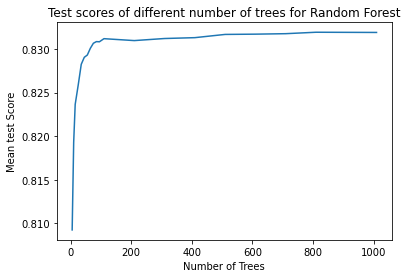

In [12]:
RFRresults = RFRresults.sort_values(by=['param_n_estimators'])
plt.plot(RFRresults['param_n_estimators'], RFRresults['mean_test_score'])


plt.xlabel('Number of Trees')
# Set the y axis label of the current axis.
plt.ylabel('Mean test Score')
# Set a title of the current axes.
plt.title('Test scores of different number of trees for Random Forest')
# Display a figure.
plt.show()

5.510781655821406


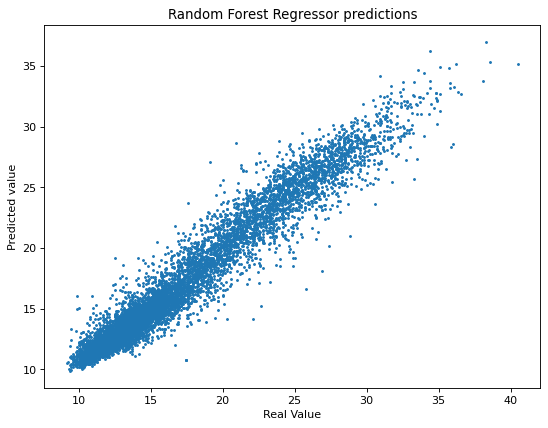

In [14]:
estimator = RandomForestRegressor(n_estimators = 700,  random_state=42).fit(X_train, y_train)
y_pred = estimator.predict(X_test)

RandomForestMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(RandomForestMAPE)


figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('Random Forest Regressor predictions')
# Display a figure.
plt.show()

6.939974601366513


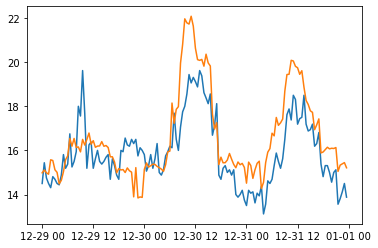

In [15]:
pred = estimator.predict(X2scaled)

RandomForestMAPE = mean_absolute_percentage_error(y2, pred) * 100
print(RandomForestMAPE)

plt.plot(df['From Timestamp'].iloc[-(3*48):],y2, label = True)
plt.plot(df['From Timestamp'].iloc[-(3*48):],pred, label = True)


# KNN


In [13]:
N = range(1,50,1)

KNN = GridSearchCV(KNeighborsRegressor(), {
    'n_neighbors': N,
    'weights': ['uniform', 'distance']
}, cv=5, return_train_score=False, verbose = 3)
KNN.fit(X1scaled, y1)
KNN_results = pd.DataFrame(KNN.cv_results_)
KNN_results = KNN_results[['param_n_neighbors', 'param_weights', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])
KNN_results

Fitting 5 folds for each of 98 candidates, totalling 490 fits
[CV 1/5] END .................n_neighbors=1, weights=uniform; total time=   1.9s
[CV 2/5] END .................n_neighbors=1, weights=uniform; total time=   2.1s
[CV 3/5] END .................n_neighbors=1, weights=uniform; total time=   1.7s
[CV 4/5] END .................n_neighbors=1, weights=uniform; total time=   1.7s
[CV 5/5] END .................n_neighbors=1, weights=uniform; total time=   1.9s
[CV 1/5] END ................n_neighbors=1, weights=distance; total time=   1.7s
[CV 2/5] END ................n_neighbors=1, weights=distance; total time=   1.8s
[CV 3/5] END ................n_neighbors=1, weights=distance; total time=   1.7s
[CV 4/5] END ................n_neighbors=1, weights=distance; total time=   1.7s
[CV 5/5] END ................n_neighbors=1, weights=distance; total time=   1.9s
[CV 1/5] END .................n_neighbors=2, weights=uniform; total time=   1.7s
[CV 2/5] END .................n_neighbors=2, we

[CV 2/5] END ................n_neighbors=11, weights=uniform; total time=   2.2s
[CV 3/5] END ................n_neighbors=11, weights=uniform; total time=   2.1s
[CV 4/5] END ................n_neighbors=11, weights=uniform; total time=   2.1s
[CV 5/5] END ................n_neighbors=11, weights=uniform; total time=   2.4s
[CV 1/5] END ...............n_neighbors=11, weights=distance; total time=   2.0s
[CV 2/5] END ...............n_neighbors=11, weights=distance; total time=   2.3s
[CV 3/5] END ...............n_neighbors=11, weights=distance; total time=   2.2s
[CV 4/5] END ...............n_neighbors=11, weights=distance; total time=   2.1s
[CV 5/5] END ...............n_neighbors=11, weights=distance; total time=   2.6s
[CV 1/5] END ................n_neighbors=12, weights=uniform; total time=   1.9s
[CV 2/5] END ................n_neighbors=12, weights=uniform; total time=   2.3s
[CV 3/5] END ................n_neighbors=12, weights=uniform; total time=   2.2s
[CV 4/5] END ...............

[CV 4/5] END ................n_neighbors=21, weights=uniform; total time=   2.3s
[CV 5/5] END ................n_neighbors=21, weights=uniform; total time=   2.6s
[CV 1/5] END ...............n_neighbors=21, weights=distance; total time=   2.1s
[CV 2/5] END ...............n_neighbors=21, weights=distance; total time=   2.5s
[CV 3/5] END ...............n_neighbors=21, weights=distance; total time=   2.5s
[CV 4/5] END ...............n_neighbors=21, weights=distance; total time=   2.4s
[CV 5/5] END ...............n_neighbors=21, weights=distance; total time=   2.8s
[CV 1/5] END ................n_neighbors=22, weights=uniform; total time=   2.1s
[CV 2/5] END ................n_neighbors=22, weights=uniform; total time=   2.5s
[CV 3/5] END ................n_neighbors=22, weights=uniform; total time=   2.4s
[CV 4/5] END ................n_neighbors=22, weights=uniform; total time=   2.3s
[CV 5/5] END ................n_neighbors=22, weights=uniform; total time=   2.6s
[CV 1/5] END ...............

[CV 1/5] END ...............n_neighbors=31, weights=distance; total time=   2.3s
[CV 2/5] END ...............n_neighbors=31, weights=distance; total time=   2.6s
[CV 3/5] END ...............n_neighbors=31, weights=distance; total time=   2.5s
[CV 4/5] END ...............n_neighbors=31, weights=distance; total time=   2.4s
[CV 5/5] END ...............n_neighbors=31, weights=distance; total time=   2.8s
[CV 1/5] END ................n_neighbors=32, weights=uniform; total time=   2.2s
[CV 2/5] END ................n_neighbors=32, weights=uniform; total time=   2.7s
[CV 3/5] END ................n_neighbors=32, weights=uniform; total time=   2.6s
[CV 4/5] END ................n_neighbors=32, weights=uniform; total time=   2.3s
[CV 5/5] END ................n_neighbors=32, weights=uniform; total time=   2.9s
[CV 1/5] END ...............n_neighbors=32, weights=distance; total time=   2.3s
[CV 2/5] END ...............n_neighbors=32, weights=distance; total time=   2.7s
[CV 3/5] END ...............

[CV 3/5] END ...............n_neighbors=41, weights=distance; total time=   2.7s
[CV 4/5] END ...............n_neighbors=41, weights=distance; total time=   2.5s
[CV 5/5] END ...............n_neighbors=41, weights=distance; total time=   3.0s
[CV 1/5] END ................n_neighbors=42, weights=uniform; total time=   2.4s
[CV 2/5] END ................n_neighbors=42, weights=uniform; total time=   3.3s
[CV 3/5] END ................n_neighbors=42, weights=uniform; total time=   2.7s
[CV 4/5] END ................n_neighbors=42, weights=uniform; total time=   2.5s
[CV 5/5] END ................n_neighbors=42, weights=uniform; total time=   3.0s
[CV 1/5] END ...............n_neighbors=42, weights=distance; total time=   2.4s
[CV 2/5] END ...............n_neighbors=42, weights=distance; total time=   2.8s
[CV 3/5] END ...............n_neighbors=42, weights=distance; total time=   2.7s
[CV 4/5] END ...............n_neighbors=42, weights=distance; total time=   2.5s
[CV 5/5] END ...............

,param_n_neighbors,param_weights,mean_test_score,rank_test_score
97,49,distance,0.821331,1
95,48,distance,0.821186,2
96,49,uniform,0.821150,3
93,47,distance,0.821063,4
94,48,uniform,0.821021,5
...,...,...,...,...
5,3,distance,0.760554,94
3,2,distance,0.745621,95
2,2,uniform,0.745543,96
1,1,distance,0.714558,97


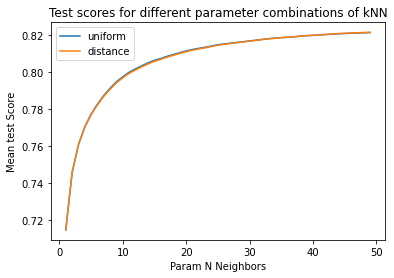

In [14]:
KNNuniform = KNN_results[(KNN_results['param_weights'] == 'uniform' )].sort_values(by = ['param_n_neighbors'])
KNNdistance = KNN_results[(KNN_results['param_weights'] == 'distance' )].sort_values(by = ['param_n_neighbors'])

plt.plot(KNNuniform['param_n_neighbors'], KNNuniform['mean_test_score'], label = 'uniform')
plt.plot(KNNdistance['param_n_neighbors'], KNNdistance['mean_test_score'], label = 'distance')

plt.xlabel('Param N Neighbors')
# Set the y axis label of the current axis.
plt.ylabel('Mean test Score')
# Set a title of the current axes.
plt.title('Test scores for different parameter combinations of kNN')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [19]:
N = range(50,100,1)

KNN2 = GridSearchCV(KNeighborsRegressor(), {
    'n_neighbors': N,
    'weights': ['uniform', 'distance']
}, cv=5, return_train_score=False, verbose = 3)
KNN2.fit(X1scaled, y1)
KNN_results2 = pd.DataFrame(KNN2.cv_results_)
KNN_results2 = KNN_results2[['param_n_neighbors', 'param_weights', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])
KNN_results2

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ................n_neighbors=50, weights=uniform; total time=   2.5s
[CV 2/5] END ................n_neighbors=50, weights=uniform; total time=   2.9s
[CV 3/5] END ................n_neighbors=50, weights=uniform; total time=   2.6s
[CV 4/5] END ................n_neighbors=50, weights=uniform; total time=   2.6s
[CV 5/5] END ................n_neighbors=50, weights=uniform; total time=   3.2s
[CV 1/5] END ...............n_neighbors=50, weights=distance; total time=   2.4s
[CV 2/5] END ...............n_neighbors=50, weights=distance; total time=   2.9s
[CV 3/5] END ...............n_neighbors=50, weights=distance; total time=   2.7s
[CV 4/5] END ...............n_neighbors=50, weights=distance; total time=   2.6s
[CV 5/5] END ...............n_neighbors=50, weights=distance; total time=   3.1s
[CV 1/5] END ................n_neighbors=51, weights=uniform; total time=   2.4s
[CV 2/5] END ................n_neighbors=51, w

[CV 2/5] END ................n_neighbors=60, weights=uniform; total time=   3.0s
[CV 3/5] END ................n_neighbors=60, weights=uniform; total time=   3.1s
[CV 4/5] END ................n_neighbors=60, weights=uniform; total time=   2.7s
[CV 5/5] END ................n_neighbors=60, weights=uniform; total time=   3.2s
[CV 1/5] END ...............n_neighbors=60, weights=distance; total time=   2.5s
[CV 2/5] END ...............n_neighbors=60, weights=distance; total time=   3.0s
[CV 3/5] END ...............n_neighbors=60, weights=distance; total time=   3.0s
[CV 4/5] END ...............n_neighbors=60, weights=distance; total time=   2.7s
[CV 5/5] END ...............n_neighbors=60, weights=distance; total time=   3.2s
[CV 1/5] END ................n_neighbors=61, weights=uniform; total time=   2.5s
[CV 2/5] END ................n_neighbors=61, weights=uniform; total time=   3.0s
[CV 3/5] END ................n_neighbors=61, weights=uniform; total time=   2.8s
[CV 4/5] END ...............

[CV 4/5] END ................n_neighbors=70, weights=uniform; total time=   2.8s
[CV 5/5] END ................n_neighbors=70, weights=uniform; total time=   3.2s
[CV 1/5] END ...............n_neighbors=70, weights=distance; total time=   2.6s
[CV 2/5] END ...............n_neighbors=70, weights=distance; total time=   3.3s
[CV 3/5] END ...............n_neighbors=70, weights=distance; total time=   2.9s
[CV 4/5] END ...............n_neighbors=70, weights=distance; total time=   2.7s
[CV 5/5] END ...............n_neighbors=70, weights=distance; total time=   3.3s
[CV 1/5] END ................n_neighbors=71, weights=uniform; total time=   2.6s
[CV 2/5] END ................n_neighbors=71, weights=uniform; total time=   3.1s
[CV 3/5] END ................n_neighbors=71, weights=uniform; total time=   2.9s
[CV 4/5] END ................n_neighbors=71, weights=uniform; total time=   2.7s
[CV 5/5] END ................n_neighbors=71, weights=uniform; total time=   3.2s
[CV 1/5] END ...............

[CV 1/5] END ...............n_neighbors=80, weights=distance; total time=   3.5s
[CV 2/5] END ...............n_neighbors=80, weights=distance; total time=   4.0s
[CV 3/5] END ...............n_neighbors=80, weights=distance; total time=   4.0s
[CV 4/5] END ...............n_neighbors=80, weights=distance; total time=   3.8s
[CV 5/5] END ...............n_neighbors=80, weights=distance; total time=   4.4s
[CV 1/5] END ................n_neighbors=81, weights=uniform; total time=   4.0s
[CV 2/5] END ................n_neighbors=81, weights=uniform; total time=   4.3s
[CV 3/5] END ................n_neighbors=81, weights=uniform; total time=   4.1s
[CV 4/5] END ................n_neighbors=81, weights=uniform; total time=   3.9s
[CV 5/5] END ................n_neighbors=81, weights=uniform; total time=   4.2s
[CV 1/5] END ...............n_neighbors=81, weights=distance; total time=   3.5s
[CV 2/5] END ...............n_neighbors=81, weights=distance; total time=   4.0s
[CV 3/5] END ...............

[CV 3/5] END ...............n_neighbors=90, weights=distance; total time=   3.3s
[CV 4/5] END ...............n_neighbors=90, weights=distance; total time=   2.9s
[CV 5/5] END ...............n_neighbors=90, weights=distance; total time=   3.5s
[CV 1/5] END ................n_neighbors=91, weights=uniform; total time=   3.0s
[CV 2/5] END ................n_neighbors=91, weights=uniform; total time=   3.3s
[CV 3/5] END ................n_neighbors=91, weights=uniform; total time=   3.1s
[CV 4/5] END ................n_neighbors=91, weights=uniform; total time=   3.0s
[CV 5/5] END ................n_neighbors=91, weights=uniform; total time=   3.5s
[CV 1/5] END ...............n_neighbors=91, weights=distance; total time=   2.8s
[CV 2/5] END ...............n_neighbors=91, weights=distance; total time=   3.3s
[CV 3/5] END ...............n_neighbors=91, weights=distance; total time=   3.0s
[CV 4/5] END ...............n_neighbors=91, weights=distance; total time=   2.9s
[CV 5/5] END ...............

,param_n_neighbors,param_weights,mean_test_score,rank_test_score
97,98,distance,0.824194,1
95,97,distance,0.824193,2
99,99,distance,0.824184,3
93,96,distance,0.824166,4
91,95,distance,0.824159,5
...,...,...,...,...
3,51,distance,0.821579,96
4,52,uniform,0.821443,97
1,50,distance,0.821400,98
2,51,uniform,0.821364,99


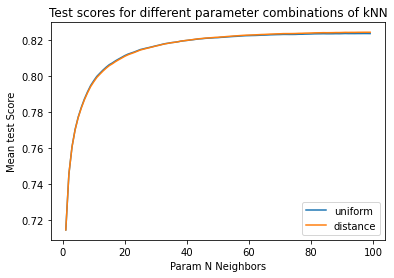

In [20]:
KNNresults = KNN_results.copy()
KNNresults = KNNresults.append(KNN_results2)

KNNuniform2 = KNNresults[(KNNresults['param_weights'] == 'uniform' )].sort_values(by = ['param_n_neighbors'])
KNNdistance2 = KNNresults[(KNNresults['param_weights'] == 'distance' )].sort_values(by = ['param_n_neighbors'])

plt.plot(KNNuniform2['param_n_neighbors'], KNNuniform2['mean_test_score'], label = 'uniform')
plt.plot(KNNdistance2['param_n_neighbors'], KNNdistance2['mean_test_score'], label = 'distance')

plt.xlabel('Param N Neighbors')
# Set the y axis label of the current axis.
plt.ylabel('Mean test Score')
# Set a title of the current axes.
plt.title('Test scores for different parameter combinations of kNN')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

7.709425881562944


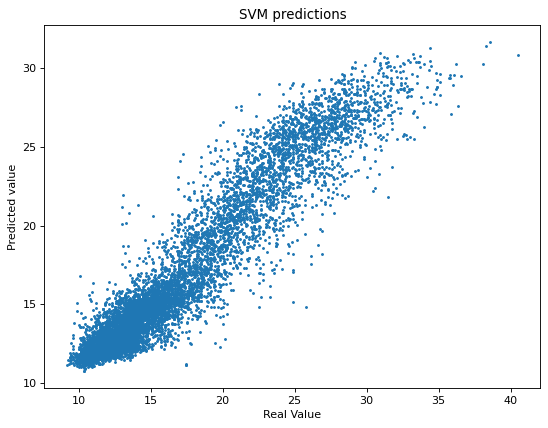

In [18]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X1scaled,y1,test_size=0.25,random_state=42) #split training:testing 75:25


estimator = KNeighborsRegressor(n_neighbors = 100, weights = 'distance').fit(X_train, y_train)
y_pred = estimator.predict(X_test)

KNNMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(KNNMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('SVM predictions')
# Display a figure.
plt.show()

4.1924897627488935


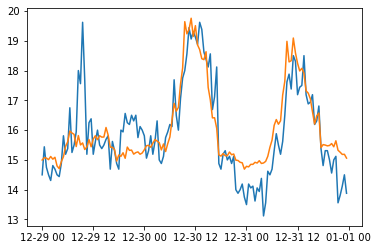

In [19]:
pred = estimator.predict(X2scaled)

RandomForestMAPE = mean_absolute_percentage_error(y2, pred) * 100
print(RandomForestMAPE)

plt.plot(df['From Timestamp'].iloc[-(3*48):],y2, label = True)
plt.plot(df['From Timestamp'].iloc[-(3*48):],pred, label = True)


# SVM Regression

In [18]:
SVM = GridSearchCV(svm.SVR(gamma='scale'), {
    'C': [0.01, 0.1, 1, 100], 
    'kernel': ['rbf','linear'],
    'epsilon': [0.01,0.1,1,10]
}, cv=5, return_train_score=False, verbose = 4)
SVM.fit(X1scaled, y1)

svm_results = pd.DataFrame(SVM.cv_results_)
svmresults = svm_results[['param_kernel','param_C','param_epsilon', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])
svmresults

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ...............C=0.01, epsilon=0.01, kernel=rbf; total time= 1.2min
[CV 2/5] END ...............C=0.01, epsilon=0.01, kernel=rbf; total time= 1.2min
[CV 3/5] END ...............C=0.01, epsilon=0.01, kernel=rbf; total time= 1.2min
[CV 4/5] END ...............C=0.01, epsilon=0.01, kernel=rbf; total time= 1.2min
[CV 5/5] END ...............C=0.01, epsilon=0.01, kernel=rbf; total time= 1.2min
[CV 1/5] END ............C=0.01, epsilon=0.01, kernel=linear; total time=  38.6s
[CV 2/5] END ............C=0.01, epsilon=0.01, kernel=linear; total time=  39.2s
[CV 3/5] END ............C=0.01, epsilon=0.01, kernel=linear; total time=  38.3s
[CV 4/5] END ............C=0.01, epsilon=0.01, kernel=linear; total time=  39.0s
[CV 5/5] END ............C=0.01, epsilon=0.01, kernel=linear; total time=  39.0s
[CV 1/5] END ................C=0.01, epsilon=0.1, kernel=rbf; total time= 1.1min
[CV 2/5] END ................C=0.01, epsilon=0.

[CV 2/5] END .....................C=1, epsilon=1, kernel=rbf; total time=  34.9s
[CV 3/5] END .....................C=1, epsilon=1, kernel=rbf; total time=  36.9s
[CV 4/5] END .....................C=1, epsilon=1, kernel=rbf; total time=  35.3s
[CV 5/5] END .....................C=1, epsilon=1, kernel=rbf; total time=  34.5s
[CV 1/5] END ..................C=1, epsilon=1, kernel=linear; total time=  35.5s
[CV 2/5] END ..................C=1, epsilon=1, kernel=linear; total time=  35.2s
[CV 3/5] END ..................C=1, epsilon=1, kernel=linear; total time=  34.8s
[CV 4/5] END ..................C=1, epsilon=1, kernel=linear; total time=  36.1s
[CV 5/5] END ..................C=1, epsilon=1, kernel=linear; total time=  35.2s
[CV 1/5] END ....................C=1, epsilon=10, kernel=rbf; total time=   0.2s
[CV 2/5] END ....................C=1, epsilon=10, kernel=rbf; total time=   0.1s
[CV 3/5] END ....................C=1, epsilon=10, kernel=rbf; total time=   0.1s
[CV 4/5] END ...............

,param_kernel,param_C,param_epsilon,mean_test_score,rank_test_score
20,rbf,1,1,0.838641,1
16,rbf,1,0.01,0.837867,2
18,rbf,1,0.1,0.837847,3
12,rbf,0.1,1,0.826354,4
8,rbf,0.1,0.01,0.826353,5
10,rbf,0.1,0.1,0.826350,6
28,rbf,100,1,0.795236,7
24,rbf,100,0.01,0.790468,8
26,rbf,100,0.1,0.789431,9
5,linear,0.01,1,0.787508,10


7.5860173640779545


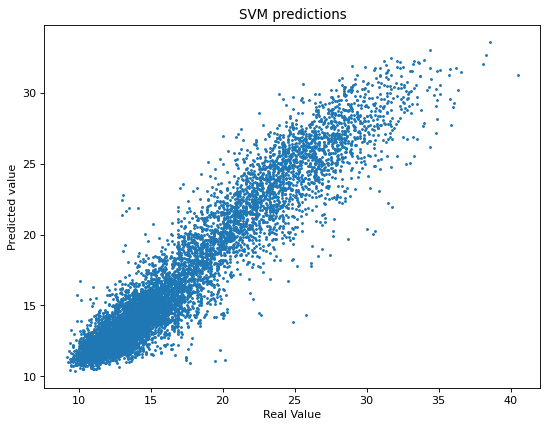

In [16]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X1scaled,y1,test_size=0.25,random_state=42) #split training:testing 75:25


estimator = svm.SVR(C = 1,  kernel = 'rbf', epsilon = 1).fit(X_train, y_train)
y_pred = estimator.predict(X_test)

SVMMAPE = mean_absolute_percentage_error(y_test, y_pred) * 100
print(SVMMAPE)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test,y_pred, s = 2.5)
plt.xlabel('Real Value')
# Set the y axis label of the current axis.
plt.ylabel('Predicted value')
# Set a title of the current axes.
plt.title('SVM predictions')
# Display a figure.
plt.show()

5.069288815454728


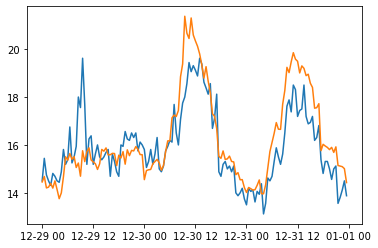

In [17]:
pred = estimator.predict(X2scaled)

SVMMAPE = mean_absolute_percentage_error(y2, pred) * 100
print(SVMMAPE)

plt.plot(df['From Timestamp'].iloc[-(3*48):],y2, label = True)
plt.plot(df['From Timestamp'].iloc[-(3*48):],pred, label = True)


# Multilayer perceptron

In [ ]:
from sklearn.neural_network import MLPRegressor

layers = range(1,50)

parameters = {'hidden_layer_sizes': layers, 'solver': ['lbfgs', 'adam'], 'max_iter': [2500], 'learning_rate_init': 10.0 ** -np.arange(1, 6, 2), 'random_state':[42]}
MLPReg = GridSearchCV(MLPRegressor(), parameters, cv=5,  verbose=2, return_train_score=False)
MLPReg.fit(X1scaled, y1)

MLPRegRes = pd.DataFrame(MLPReg.cv_results_)
MLP_results = MLPRegRes[['rank_test_score', 'mean_test_score', 'param_hidden_layer_sizes', 'param_solver', 'param_max_iter', 'param_learning_rate_init']].sort_values(by=['rank_test_score'])
MLP_results

Fitting 5 folds for each of 294 candidates, totalling 1470 fits
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.5s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.2s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.3s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.1s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.3s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.6s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   0.9s
[CV] END hidden_layer_sizes=1, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=1, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.7min
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   5.2s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   7.5s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   9.1s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   8.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   2.1s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.3s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.0s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.2s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.2s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.1s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=   5.2s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=   6.6s
[CV] END hidden_layer_sizes=2, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=   8.8s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.8s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  11.9s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  10.6s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  11.0s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  11.6s
[CV] END hidden_layer_sizes=2, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  12.4s
[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=   5.2s
[CV] END hidden_layer_sizes=2

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=   8.6s
[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=2, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.8min
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.4s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   6.2s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.8s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   3.8s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   2.0s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.6s
[CV] END hidden_layer_sizes=3, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.6s
[CV] END hidden_layer_sizes=3, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=3, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.8min
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   2.9s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   9.1s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.8s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   2.8s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   1.9s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=4, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.3s
[CV] END hidden_layer_sizes=4, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=4, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=4, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=4, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=4, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=4, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.8min
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   4.6s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   4.4s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   3.5s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   4.2s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   6.0s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=5, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   0.9s
[CV] END hidden_layer_sizes=5, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=5, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=5, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=5, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=5, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=5, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.0min
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   6.1s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   6.3s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   8.4s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   5.2s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  14.1s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.0s
[CV] END hidden_layer_sizes=6, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.1s
[CV] END hidden_layer_sizes=6, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=6, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.0min
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   7.0s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  11.9s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  10.8s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  11.0s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  12.5s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.7s
[CV] END hidden_layer_sizes=7, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=7, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=7, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=7, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=7, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=7, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=7, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 1.9min
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   8.4s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  14.6s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  17.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  18.6s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  15.8s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   0.8s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=   8.6s
[CV] END hidden_layer_sizes=8, learning_rat

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  18.2s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  14.5s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  21.8s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  13.4s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  18.5s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  12.2s
[CV] END hidden_layer_sizes=8, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  24.5s
[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=   8.3s
[CV] END hidden_layer_sizes=8

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  18.2s
[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  14.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=8, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.0min
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   9.8s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  20.5s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  12.6s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  14.7s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  13.1s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.5s
[CV] END hidden_layer_sizes=9, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.5s
[CV] END hidden_layer_sizes=9, learning_r

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=9, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.0min
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  15.8s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   9.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  23.4s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  20.3s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  19.1s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.1s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.0s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.3s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.4s
[CV] END hidden_layer_sizes=10, learn

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  23.2s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  20.1s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  19.5s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  16.7s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  11.4s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  23.3s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  10.8s
[CV] END hidden_layer_sizes=10, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  14.6s
[CV] END hidden_layer

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  23.9s
[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  19.4s
[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  19.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=10, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.1min
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  16.7s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=   7.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  26.1s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  10.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  25.6s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.2s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.3s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.8s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.3s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  18.2s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=   9.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  27.2s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  10.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  25.3s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  23.9s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  14.6s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  23.5s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  35.4s
[CV] END hidden_layer_sizes=11, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  19.6s
[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  16.7s
[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=   8.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  25.7s
[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  10.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  25.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=11, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  24.9s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  17.4s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  25.5s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  18.2s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  18.6s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.7s
[CV] END hidden_layer_sizes=12, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.1s
[CV] END hidden_layer_sizes=12, l

C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=12, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  27.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  29.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  27.2s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  17.4s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  24.3s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.2s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.7s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.2s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  27.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  28.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  29.3s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  17.5s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  25.4s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  25.9s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  14.8s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  20.5s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  13.0s
[CV] END hidden_layer_sizes=13, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  18.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  27.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  27.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  27.2s
[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  17.6s
[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  24.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=13, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  33.5s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  18.3s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  23.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  29.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  29.7s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.4s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.4s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.3s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.0s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  29.4s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  18.4s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  27.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  34.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  30.7s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  20.3s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  23.8s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  30.1s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  18.3s
[CV] END hidden_layer_sizes=14, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  18.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  29.6s
[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  19.2s
[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  22.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  29.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  29.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=14, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.3min
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  32.2s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  25.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  31.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  32.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  33.3s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.3s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.7s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.5s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.8s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.8s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  32.8s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  25.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  31.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  32.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  33.5s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  16.0s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  32.0s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  19.5s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  19.0s
[CV] END hidden_layer_sizes=15, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  20.4s
[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  31.6s
[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  25.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  31.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  32.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  33.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=15, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  32.7s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  16.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  32.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  32.1s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  23.8s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.2s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.7s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.4s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.2s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  32.8s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  17.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  32.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  33.1s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  23.3s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  19.8s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  18.5s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  25.1s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  14.9s
[CV] END hidden_layer_sizes=16, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  27.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  34.0s
[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  18.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  36.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  33.2s
[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  24.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=16, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  36.3s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  34.1s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  27.1s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  33.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  36.6s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.7s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.6s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.4s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.6s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  36.4s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  34.2s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  27.2s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  33.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  36.5s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  13.5s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  17.5s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  13.8s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  19.3s
[CV] END hidden_layer_sizes=17, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  12.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  36.2s
[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  35.1s
[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  27.3s
[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  34.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  35.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=17, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.3min
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  28.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  38.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  36.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  36.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  37.7s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.7s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.5s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.6s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.0s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.4s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  28.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  38.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  36.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  36.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  38.1s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  26.5s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  28.0s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  17.8s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  19.6s
[CV] END hidden_layer_sizes=18, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  18.4s
[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  28.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  37.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  36.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  36.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  38.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=18, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  41.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  41.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  41.0s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  33.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  41.4s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.2s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.2s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.9s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.3s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  40.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  41.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  40.6s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  33.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  41.5s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  21.1s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  18.9s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  32.7s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  18.0s
[CV] END hidden_layer_sizes=19, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  27.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  39.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  41.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  40.6s
[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  33.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  44.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=19, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.9min
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  38.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  40.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  41.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  40.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  41.5s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.4s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.0s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.2s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.6s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.7s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  39.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  41.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  41.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  41.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  44.6s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  22.4s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  25.8s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  26.4s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  29.0s
[CV] END hidden_layer_sizes=20, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  28.6s
[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  39.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  40.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  41.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  42.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  41.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 2.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=20, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  44.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  45.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  46.1s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  39.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  43.8s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.8s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.7s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.8s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.7s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  45.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  44.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  44.8s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  40.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  32.9s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  55.9s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  47.3s
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time= 1.0min
[CV] END hidden_layer_sizes=21, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  46.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min
[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 4.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 4.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 4.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 5.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=21, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 5.1min
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  52.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.1s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   7.8s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.2s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   5.5s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   8.1s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  29.3s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  46.3s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  43.7s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  48.4s
[CV] END hidden_layer_sizes=22, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  36.8s
[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  58.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 4.9min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 4.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=22, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  45.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  47.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  46.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  46.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  46.9s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.2s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.2s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.5s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.1s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  44.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  50.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  48.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  45.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  46.9s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  22.7s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  23.4s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  18.0s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  31.9s
[CV] END hidden_layer_sizes=23, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  24.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  44.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  47.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  46.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  46.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  51.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=23, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  48.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  50.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  47.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  48.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  51.4s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.8s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   7.4s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.1s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   5.7s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  54.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  52.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  48.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  50.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  53.4s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  51.3s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  30.2s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  31.8s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  32.3s
[CV] END hidden_layer_sizes=24, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  29.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  53.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  51.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  48.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  53.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  50.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=24, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  51.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  52.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  57.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  52.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  51.6s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.6s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.5s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.2s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.2s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  48.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  51.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  54.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  50.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  53.6s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  29.3s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  20.5s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  35.5s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  17.5s
[CV] END hidden_layer_sizes=25, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  26.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  49.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  54.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  50.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  55.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  51.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=25, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  56.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  55.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  52.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  55.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  52.0s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   7.1s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.6s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   5.5s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.3s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  53.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  54.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  56.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  53.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  53.8s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  29.4s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  36.7s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  28.3s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  23.5s
[CV] END hidden_layer_sizes=26, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  20.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  53.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  52.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  51.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  54.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  52.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=26, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  53.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  53.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  53.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  53.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  53.8s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   5.2s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.3s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.5s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.0s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   5.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  55.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  54.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  54.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  55.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  59.8s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  30.0s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  38.8s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  28.3s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  20.7s
[CV] END hidden_layer_sizes=27, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  20.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  52.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  54.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  54.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  52.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  53.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=27, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  58.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  57.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  56.5s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.4s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.2s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.5s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.8s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  57.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time=  55.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min
[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  36.5s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  24.6s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  41.6s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  36.2s
[CV] END hidden_layer_sizes=28, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  24.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  56.4s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  54.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  55.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  57.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  55.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=28, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  58.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  57.2s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  57.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.9s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=  11.5s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   5.2s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.0s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  29.7s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  49.3s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  46.8s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  39.0s
[CV] END hidden_layer_sizes=29, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  41.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 4.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 4.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 4.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=29, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min
[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.3s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.6s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.7s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.6s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   5.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min
[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  28.1s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  27.8s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  28.4s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  25.1s
[CV] END hidden_layer_sizes=30, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  23.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  59.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  59.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  59.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=30, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  59.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time=  59.8s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.5s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.8s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.2s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.2s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min
[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  31.0s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  28.6s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  35.5s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  42.5s
[CV] END hidden_layer_sizes=31, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  24.5s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  58.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time=  59.7s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.0min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=31, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min
[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   8.1s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.9s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.3s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   5.3s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.3s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min
[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  31.0s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  39.2s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  27.8s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  23.3s
[CV] END hidden_layer_sizes=32, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  26.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.7min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=32, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min
[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   6.7s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.5s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=  11.0s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   5.2s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.1s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min
[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  21.7s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  20.3s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  15.5s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  33.4s
[CV] END hidden_layer_sizes=33, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  21.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.4min
[CV] END hidden_layer_sizes=33, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 2.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 2.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.6min
[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   5.1s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.6s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.9s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.6s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.8s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.7min
[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  36.9s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time= 1.1min
[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  21.8s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  28.8s
[CV] END hidden_layer_sizes=34, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  30.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=34, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 4.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=35, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=35, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=35, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.8min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=35, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=35, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.5min
[CV] END hidden_layer_sizes=35, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   5.7s
[CV] END hidden_layer_sizes=35, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.3s
[CV] END hidden_layer_sizes=35, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.7s
[CV] END hidden_layer_sizes=35, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   1.9s
[CV] END hidden_layer_sizes=35, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   8.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=35, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=35, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=35, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=35, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=35, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min
[CV] END hidden_layer_sizes=35, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  58.8s
[CV] END hidden_layer_sizes=35, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time= 1.1min
[CV] END hidden_layer_sizes=35, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  46.8s
[CV] END hidden_layer_sizes=35, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  27.8s
[CV] END hidden_layer_sizes=35, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  29.6s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=35, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=35, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=35, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=35, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=35, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=35, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.6min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=35, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=35, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=35, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=35, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=36, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=36, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=36, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=36, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=36, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.1min
[CV] END hidden_layer_sizes=36, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   4.3s
[CV] END hidden_layer_sizes=36, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.9s
[CV] END hidden_layer_sizes=36, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   5.0s
[CV] END hidden_layer_sizes=36, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   2.8s
[CV] END hidden_layer_sizes=36, learning_rate_init=0.1, max_iter=2500, random_state=42, solver=adam; total time=   3.0s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=36, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=36, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=36, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=36, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=36, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min
[CV] END hidden_layer_sizes=36, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  37.4s
[CV] END hidden_layer_sizes=36, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  34.0s
[CV] END hidden_layer_sizes=36, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  28.7s
[CV] END hidden_layer_sizes=36, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  28.8s
[CV] END hidden_layer_sizes=36, learning_rate_init=0.001, max_iter=2500, random_state=42, solver=adam; total time=  34.9s


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=36, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=36, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=36, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=36, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.3min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END hidden_layer_sizes=36, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=lbfgs; total time= 1.2min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=36, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.5min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=36, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 3.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=36, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time= 4.4min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END hidden_layer_sizes=36, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time=10.1min


C:\Users\salda\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END hidden_layer_sizes=36, learning_rate_init=1e-05, max_iter=2500, random_state=42, solver=adam; total time=  12.2s


In [ ]:
MLP_results1 = MLP_results[MLP_results['mean_test_score']>0.5]


MLP_adam = MLP_results1[(MLP_results1['param_solver'] == 'adam' )].sort_values(by = ['param_hidden_layer_sizes'])
MLP_lbfgs = MLP_results1[(MLP_results1['param_solver'] == 'lbfgs' )].sort_values(by = ['param_hidden_layer_sizes'])

plt.plot(MLP_adam['param_hidden_layer_sizes'], MLP_adam['mean_test_score'], label = 'adam')
plt.plot(MLP_lbfgs['param_hidden_layer_sizes'], MLP_lbfgs['mean_test_score'], label = 'lbfgs')

plt.xlabel('Number of hidden layers')
# Set the y axis label of the current axis.
plt.ylabel('Mean test Score')
# Set a title of the current axes.
plt.title('Test scores of different number of hidden layers for Multi Layer Perceptron')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()